In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by agency

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [3]:
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
table_df.loc['Total','agency'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,agency,observed_boardings,model_boardings,diff,perc_diff
0,2,King County Metro,"253,313.62","292,748.73","39,435.11",15.57%
1,5,Sound Transit,"113,374.00","128,042.38","14,668.38",12.94%
2,0,Community Transit,"25,962.00","20,938.32","-5,023.68",-19.35%
3,4,Pierce Transit,"21,185.00","16,823.61","-4,361.39",-20.59%
4,6,Washington Ferries,"9,278.21","8,409.83",-868.38,-9.36%
5,3,Kitsap Transit,"7,789.00","32,417.93","24,628.93",316.20%
6,1,Everett Transit,"4,201.00","2,457.77","-1,743.23",-41.50%
7,Total,Total,"435,102.83","501,838.56","66,735.74",15.34%


In [4]:
# fig = px.bar(plot_df.sort_values('source'), x="agency", y="count",
#              color="source", barmode="group",
#              title="transit boardings by agency")
# fig.update_layout(height=400, width=700, font=dict(size=11),
#                   yaxis_tickformat = '.2f')
# fig.show()

### boarding by key route

In [5]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,973 W Sea Water Taxi,759.00,927.33,168.33,22.18%
1,975 Vashn Water Taxi,338.00,804.25,466.25,137.94%
2,WSF Edmonds-Kingston,"1,500.13",242.07,"-1,258.06",-83.86%
3,WSF Seattle-Bain Isl,"5,513.69","5,606.59",92.90,1.68%
4,WSF Seattle-Brem,"1,188.97",347.08,-841.88,-70.81%
5,WSF Fauntleroy-Swrth,142.56,563.99,421.42,295.61%
6,WSF Fauntleroy-Vashn,560.04,"1,390.02",829.97,148.20%
7,WSF Vashon-Southwrth,107.76,107.78,0.02,0.02%
8,WSF Pt Def-Tahlequah,265.05,152.31,-112.75,-42.54%


r^2 : 0.9276684378722422


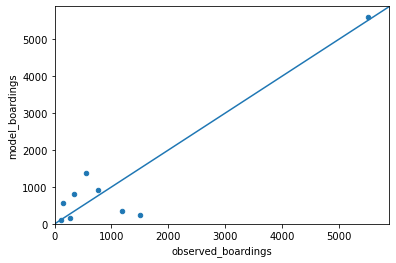

In [6]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

##### bikes on ferry

In [7]:
df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
df['route_code'] = df['route_code'].astype('int')
df[['route_code','description', '@bvol']]

,route_code,description,@bvol
4,4203,Seattle-Kingston FF,678.00
2,4200,Seattle-Bremerton FF,394.60
3,4201,Brem-Pt Orchard FF,393.40
0,1973,973 W Sea Water Taxi,276.20
1,1975,975 Vashn Water Taxi,147.20
7,5002,WSF Seattle-Bain Isl,96.00
11,5007,WSF Pt Def-Tahlequah,63.00
10,5005,WSF Fauntleroy-Vashn,55.40
6,5001,WSF Edmonds-Kingston,32.00
8,5003,WSF Seattle-Brem,26.00


In [8]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Link Red Line,"79,522.00","62,336.89","-17,185.11",-21.61%
1,Sounder South,"6,038.00","9,366.14","3,328.14",55.12%
2,Sounder North,316.00,13.86,-302.14,-95.61%


r^2 : 0.9972061745647726


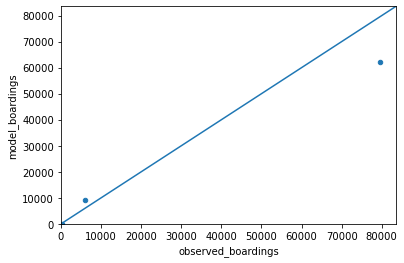

In [9]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [10]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
6,E Line RapidRide,"11,426.00","17,541.11","6,115.11",53.52%
4,C Line RapidRide,"7,250.00","13,329.37","6,079.37",83.85%
1,KC Metro 40,"7,208.00","10,635.69","3,427.69",47.55%
10,Sound Transit 550,"3,351.00","9,381.03","6,030.03",179.95%
0,KC Metro 7,"9,954.00","9,269.26",-684.74,-6.88%
5,D Line RapidRide,"9,044.00","7,942.53","-1,101.47",-12.18%
2,A Line RapidRide,"8,412.00","6,260.26","-2,151.74",-25.58%
7,F Line RapidRide,"4,748.00","5,015.98",267.98,5.64%
3,B Line RapidRide,"4,177.00","3,690.62",-486.38,-11.64%
9,First Hill Streetcar,"3,900.45",893.41,"-3,007.05",-77.09%


r^2 : 0.7461368105947098


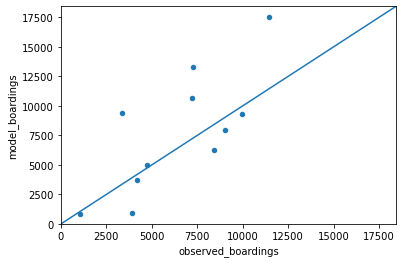

In [11]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### boarding on lines by agency

r^2 Community Transit: 0.930399167044112
r^2 Everett Transit: 0.9445091837056703


r^2 King County Metro: 0.8943281518693836
r^2 Kitsap Transit: 0.8665746117579473
r^2 Pierce Transit: 0.7591874423198148


r^2 Sound Transit: 0.9862112528386067
r^2 Washington Ferries: 0.9337675649271691

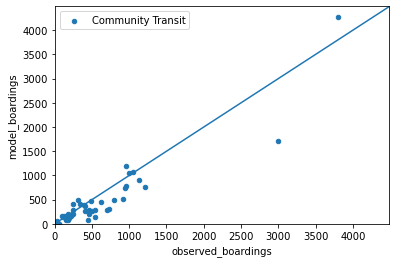

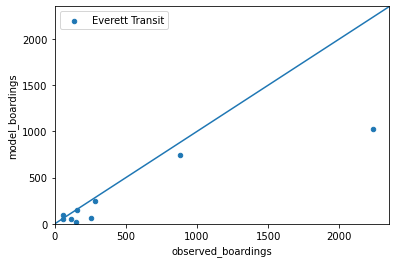

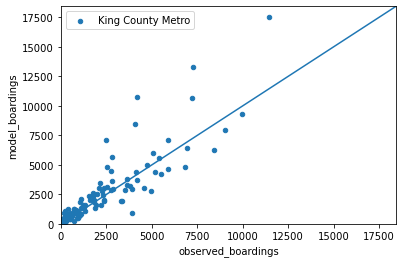

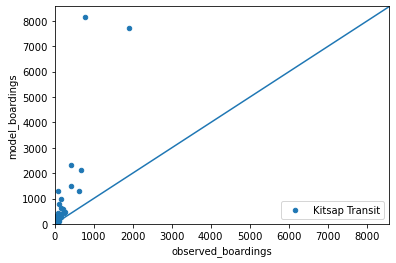

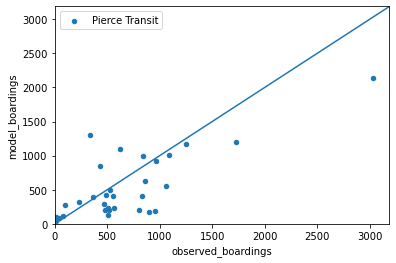

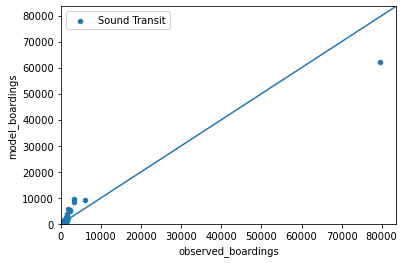

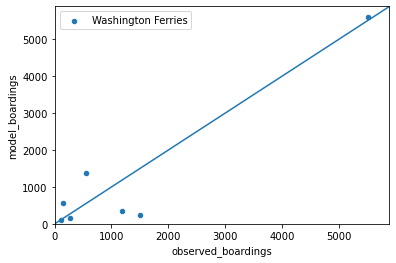

In [12]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [13]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"6,134.00","3,732.28","-2,401.72",-39.15%
Westlake,"8,845.00","7,354.72","-1,490.28",-16.85%
University St,"4,324.00","4,872.53",548.53,12.69%
Pioneer Square,"2,400.00","4,261.30","1,861.30",77.55%
Int'l District,"4,399.00","1,490.32","-2,908.68",-66.12%
Capitol Hill,"7,667.00","5,047.64","-2,619.36",-34.16%
Stadium,"1,731.00",465.54,"-1,265.46",-73.11%
SODO,"1,669.00","2,461.93",792.93,47.51%
Beacon Hill,"2,147.00",817.70,"-1,329.30",-61.91%


In [14]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/University St'
df_combined.loc[['University St'],'station_group'] = 'Westlake/University St'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/University St',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"6,134.00","3,732.28","-2,401.72",-39.15%
Capitol Hill,"7,667.00","5,047.64","-2,619.36",-34.16%
Westlake/University St,"13,169.00","12,227.25",-941.75,-7.15%
Pioneer Square/Int'l District,"6,799.00","5,751.62","-1,047.38",-15.40%
Stadium/SODO,"3,400.00","2,927.47",-472.53,-13.90%
Beacon Hill/Mount Baker,"4,008.00","1,737.94","-2,270.06",-56.64%
Columbia City,"1,630.00",885.37,-744.63,-45.68%
Othello/Rainier Beach,"3,525.00","1,899.25","-1,625.75",-46.12%
Tukwila Int'l Blvd,"2,298.00","1,611.33",-686.67,-29.88%


### light rail stop transfers

In [15]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.92,-99.00,99.92,-100.93%
Westlake,0.16,0.36,-0.21,-56.78%
University St,0.24,0.20,0.04,17.73%
Pioneer Square,0.47,0.16,0.31,193.27%
Int'l District,0.68,0.45,0.23,50.84%
Capitol Hill,0.07,-99.00,99.07,-100.07%
Stadium,0.23,0.12,0.11,93.29%
SODO,0.47,0.31,0.15,49.36%
Beacon Hill,0.33,0.35,-0.02,-6.53%
